# Prediction of Map Difficulty with Replay Error

I hypothesize that using quantiles of the replay errors, it's possible to achieve a reliable method of map difficulty sorting.
This assumes that our data is sufficiently representative to achieve this.

`load_maps()` loads an error DF with its osu map in a tuple.
For this notebook, we modify it to get its metadata too

In [46]:
from opal.utils import load_maps as _load_maps


def load_maps(n: int = None, cache_reset: bool = False, separate_tails: bool = False):
    if separate_tails:
        for df, df_t, osu in _load_maps(n=n, cache_reset=cache_reset, separate_tails=True):
            yield df, df_t, osu, osu.metadata(False)
    else:
        for df, osu in _load_maps(n=n, cache_reset=cache_reset, separate_tails=False):
            yield df, osu, osu.metadata(False)

## Play Error Analysis

We have 4 types of columns

- `col_x` OHE of if column `x` is hit
- `is_held_x` OHE of if column `x` is held
- `diff` difference between the current pattern group and the previous
- `error` player error

### Histogram

We can plot the histogram of the error, as shown below

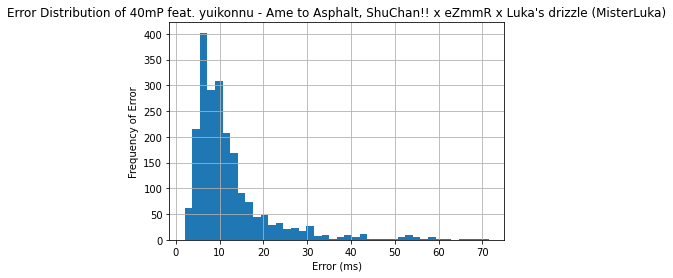

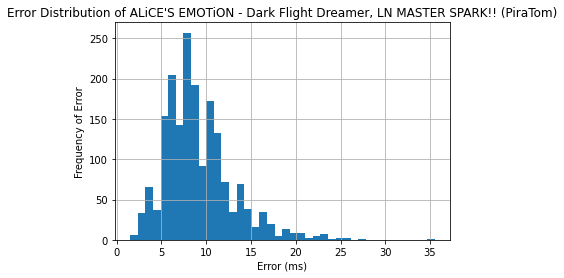

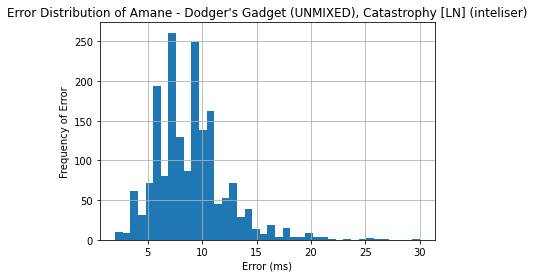

In [47]:
from matplotlib import pyplot as plt

for df, osu, meta in load_maps(3):
    df[['error']].hist(bins=40)
    plt.xlabel("Error (ms)")
    plt.ylabel("Frequency of Error")
    _ = plt.title(f"Error Distribution of {meta}")

## ECDF

One issue with histograms is binning bias, the shape changes w.r.t. its bin size.
**ECDFs** doesn't suffer from it, though it does take some time to understand

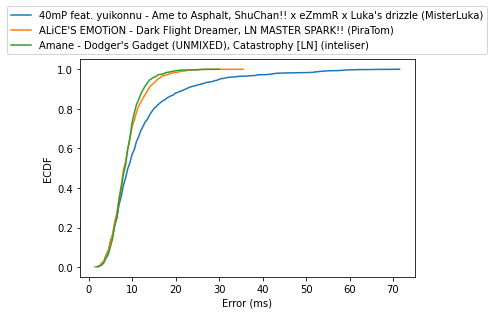

In [48]:
from opal.utils import ecdf

for df, osu, meta in load_maps(3):
    x = ecdf(df[['error']])
    x.plot(label=meta)
_ = plt.xlabel("Error (ms)")
_ = plt.ylabel("ECDF")
_ = plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1))

We see that the ECDF tells difficulty of the map in multiple dimensions.

The map is harder when:
- the curve is rightwards
- the upper quantile of the curve pitches slower
    - upper quantiles are of larger values


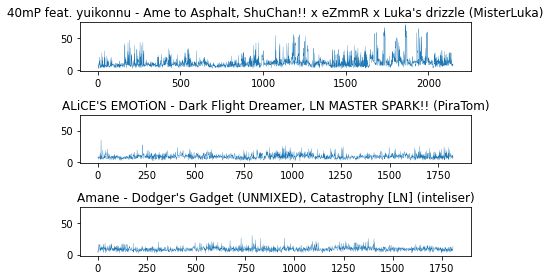

In [49]:
fig, axs = plt.subplots(3, 1, sharey=True)
for ax, (df, osu, meta) in zip(axs, load_maps(3)):
    ax.plot(df[['error']], linewidth=0.3)
    ax.set_title(meta)
_ = fig.tight_layout()

In [50]:
import numpy as np

qs = np.linspace(0.5, 1, 25)
print("Quantile Error")

for df, osu, meta in load_maps(3):
    print(meta)
    print(np.quantile(df['error'], qs).astype(int))


Quantile Error
40mP feat. yuikonnu - Ame to Asphalt, ShuChan!! x eZmmR x Luka's drizzle (MisterLuka)
[ 9  9 10 10 10 11 11 11 12 12 12 13 14 14 15 16 17 18 20 22 24 28 32 43
 71]
ALiCE'S EMOTiON - Dark Flight Dreamer, LN MASTER SPARK!! (PiraTom)
[ 8  8  9  9  9  9  9  9 10 10 10 10 11 11 11 11 12 13 13 14 14 15 16 19
 35]
Amane - Dodger's Gadget (UNMIXED), Catastrophy [LN] (inteliser)
[ 8  9  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 12 12 12 13 14 15 17
 30]


Using the plot and quantiles, we see that:

- Ame to Asphalt is hardest
- Dark Flight Dreamer has similar difficulty to Dodger's Gadget

### Summary of Error ECDF

We see that ECDF is a simple way to discern difficulty of a map, however, let's take a look at ECDFs of more maps

196it [00:02, 86.31it/s] 


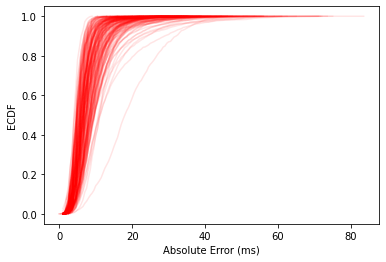

In [51]:
from tqdm import tqdm

for df, osu, meta in tqdm(load_maps()):
    x = ecdf(df[['error']])
    x.plot(color='red', alpha=0.1)
_ = plt.xlabel("Absolute Error (ms)")
_ = plt.ylabel("ECDF")

We see performances of consistent shapes, with a few outliers, let's further separate them by taking its cube root

196it [00:03, 64.17it/s]


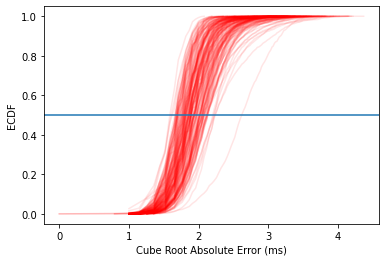

In [52]:
for df, osu, meta in tqdm(load_maps()):
    x = ecdf(df[['error']] ** (1 / 3))
    x.plot(color='red', alpha=0.1)

_ = plt.xlabel("Cube Root Absolute Error (ms)")
_ = plt.ylabel("ECDF")
ax = plt.gca()
plt.axhline(0.5)

We see a spaghetti of lines in the middle, consider the following:

- If we slice a specific **ECDF = x**, at the line shown, we have an order of maps.
- Maps further to the right (larger error) are more difficult, vice versa.
- If with more trials with different x, that agrees that Map A > B, we find more confidence that Map A > B.

We can aggregate this by doing a rank sum

In [53]:
# Let's firstly yield the quantiles from 0.1 to 0.9 for the maps
qs_bin = np.linspace(0.1, 0.9, 9)
ar_qs = []
metas = []
for df, osu, meta in load_maps(3):
    ar_qs.append(np.quantile(df[['error']], qs_bin))
    metas.append(meta)

ar_qs = np.asarray(ar_qs)

In [54]:
# Then we use scipy stats to rank the data
# Same values are ranked the same
import pandas as pd
from scipy.stats import rankdata

srs = pd.Series(rankdata(ar_qs, axis=0).sum(axis=1), index=metas, name="weight")
srs

40mP feat. yuikonnu - Ame to Asphalt, ShuChan!! x eZmmR x Luka's drizzle (MisterLuka)    23.5
ALiCE'S EMOTiON - Dark Flight Dreamer, LN MASTER SPARK!! (PiraTom)                       15.5
Amane - Dodger's Gadget (UNMIXED), Catastrophy [LN] (inteliser)                          15.0
Name: weight, dtype: float64

The results are consistent with what we found, Ame to Asphalt is heavily favored to be the hardest.
Followed by the next 2 which are closely weighted.

Let's take a look at more maps, see if they are consistent

In [55]:
# Let's firstly yield the quantiles from 0.1 to 0.9 for the maps
ar_qs = []
metas = []
for df, osu, meta in tqdm(load_maps(n=None)):
    metas.append(osu.metadata(False))
    ar_qs.append(np.quantile(df[['error']], qs_bin))

ar_qs = np.asarray(ar_qs)
# Then we use scipy stats to rank the data
# Same values are ranked the same
import pandas as pd
from scipy.stats import rankdata

srs = pd.Series(rankdata(ar_qs, axis=0).sum(axis=1), index=metas, name="weight")
srs.sort_values(ascending=False)

196it [00:00, 308.01it/s]


ueotan - Mario Paint (Time Regression Mix for BMS), D-ANOTHER (Fullerene-)                   1764.0
Camellia - Kamah (Scythe), Set them free (Ticle)                                             1744.0
Suzuki Konomi - One Day Sky, The Final ShuChan!! (shuniki)                                   1738.0
Kommisar - Southern Waters Assault 8bit, LN Master (Gekido-)                                 1726.5
Camellia - Kamah (Scythe), Bringo's Insane (Ticle)                                           1724.0
                                                                                              ...  
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Distress (AutotelicBrown)                        94.5
Seiryu - AO-INFINITY, Autumn (Tailsdk)                                                         79.0
Yuuna Sasara feat. Tai no Kobone - Imperishable Night 2006, 4K PROGUY's Normal (xxbidiao)      40.0
Caravan Palace - Lone Digger, Jack Digger (XeoStyle)                                           24.0


We see an obvious problem here, because by sorting, we eliminate the absolute difference between maps.
Mario Paint is miles harder than many others, but it's rated higher only slightly.

Take a look at the ECDF of the 80% Quantile. It's similar to a Normal Distribution

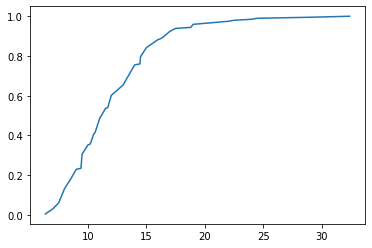

In [56]:
_ = ecdf(pd.Series(ar_qs[:, 8])).plot()

The idea is to approximate this normal distribution, and use stdev as weight instead


In [57]:
from sklearn.preprocessing import scale

x = scale(ar_qs, axis=0)
# Assert that std is 1
print(np.std(x[:, 0]))
# Assert that mean is 0
print(np.mean(x[:, 0]))

1.0000000000000004
-6.072240216317183e-16


In [58]:
srs = pd.Series(x.sum(axis=1), index=metas, name="weight")
srs.sort_values(ascending=False)

ueotan - Mario Paint (Time Regression Mix for BMS), D-ANOTHER (Fullerene-)                   53.480893
Suzuki Konomi - One Day Sky, The Final ShuChan!! (shuniki)                                   24.303028
Camellia - Kamah (Scythe), Set them free (Ticle)                                             23.129266
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Trouble 1.4x (AutotelicBrown)                  20.487248
Kommisar - Southern Waters Assault 8bit, LN Master (Gekido-)                                 19.920157
                                                                                               ...    
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Distress (AutotelicBrown)                     -11.879475
Seiryu - AO-INFINITY, Autumn (Tailsdk)                                                      -12.267582
Yuuna Sasara feat. Tai no Kobone - Imperishable Night 2006, 4K PROGUY's Normal (xxbidiao)   -13.671309
Caravan Palace - Lone Digger, Jack Digger (XeoStyle)                     

## Summary of ECDF Quantile Sorting

This looks great! However, we see some anomalies.

Set them free is hard, but not **that hard**.
We see a clear anomalous trend here: LN maps are overrated.
This is because LNs have 2 points of errors, the head & tail.

We stop here because there's insufficient data from our replays, see below.

## Thoughts on Map Difficulty with Replay Error

While, initially, was a decent idea, there are a clear drawbacks.
- We don't have enough data, 10 replays per map is insufficient.
- Some data are not comparable. For example, Kamah was recently released, thus scores are still volatile, comparing it to matured maps will only overrate it.

## Next Steps

Thus, it's conclusive that this method is not reliable and should be shelved for a more consistent one like Collaborative Filtering with scores / accuracy, which is more universally agreeable to sort difficulty